# Tutorial

1. Check GPU

In [623]:
!nvidia-smi

Mon Nov 25 23:39:49 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.120                Driver Version: 550.120        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        Off |   00000000:06:00.0 Off |                  Off |
|  0%   37C    P8             21W /  450W |    4991MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [624]:
!pip install opencv-python torch torchvision torchaudio numpy matplotlib pillow

In [625]:
# Defining a CNN
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import WeightedRandomSampler
from torch.utils.data import random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import warnings
warnings.filterwarnings("ignore")


In [626]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")

# Specify hyperparameters
minibatch_size = 20
learning_rate = 0.01
epochs = 50

Using cuda device


In [627]:
# Define loader function
def custom_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        img = img.crop((50, 60, 750, 460))  #Size: 700x400 px
        img.load()
        return img

# Path of images (local to accelerate loading)
path = "data/Coil_Vision/01_train_val_test"

In [628]:
# Transform function for loading
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5), (0.5))])

# Create dataset out of folder structure
dataset = datasets.ImageFolder(path, transform=transform, loader=custom_loader)
train_set, val_set, test_set = random_split(dataset, [round(0.5*len(dataset)), 
                                                      round(0.3*len(dataset)), 
                                                      round(0.2*len(dataset))])

In [629]:
# Define a sampler to balance the classes
# training dataset
lbls = [dataset[idx][1] for idx in train_set.indices]
bc = np.bincount(lbls)
p_nOK = bc.sum()/bc[0]
p_OK = bc.sum()/bc[1]
lst_train = [p_nOK if lbl==0 else p_OK for lbl in lbls]
train_sampler = WeightedRandomSampler(weights=lst_train, num_samples=len(lbls))

In [630]:
# Define loader with batchsize
train_loader = DataLoader(dataset=train_set, batch_size=minibatch_size, sampler=train_sampler)
val_loader = DataLoader(dataset=val_set, batch_size=minibatch_size, shuffle=True)
test_loader = DataLoader(dataset=test_set, shuffle=True)

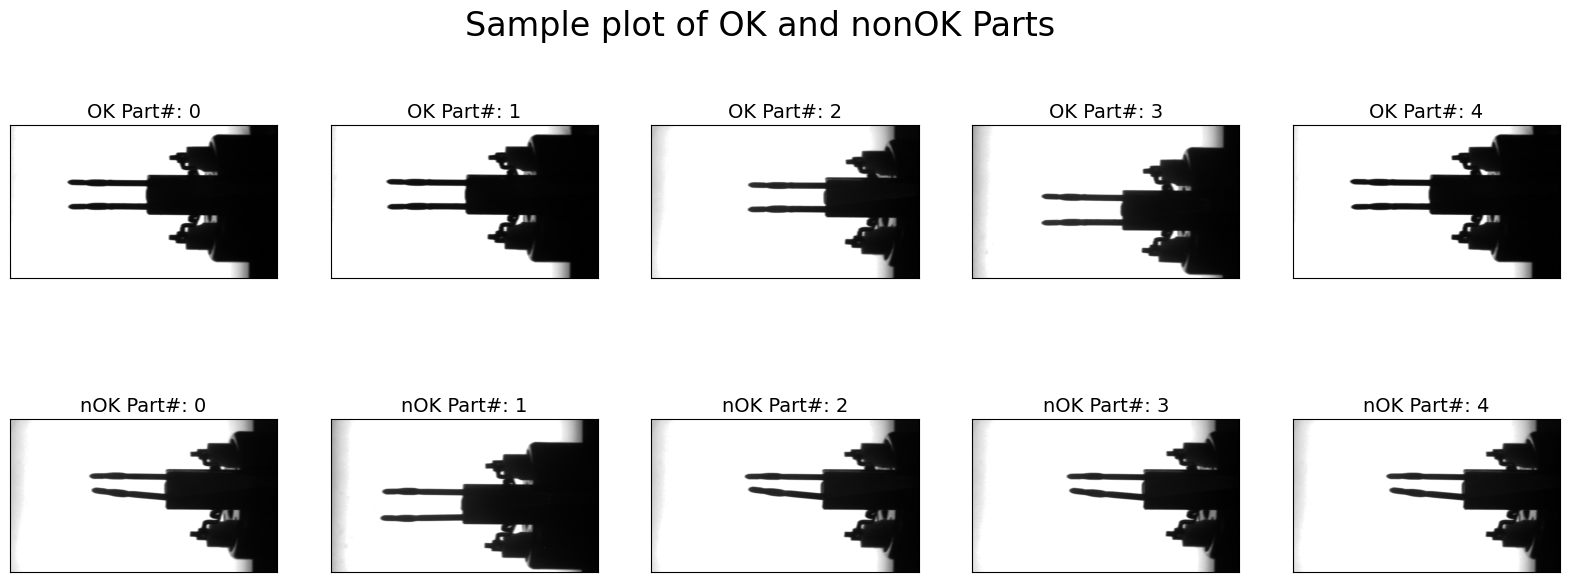

In [631]:
# Figure and axes object
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20,7), sharey=True, sharex=True)

count_OK = 0
count_nOK = 0

# Loop over loader batches
for (batch_data, batch_lbls) in train_loader:
    
    # Loop over batch_lbls
    for i, lbl in enumerate(batch_lbls):
        
        # If label is 0 (nOK) plot image in row 1
        if (lbl.item() == 0) and (count_nOK < 5):
            axs[1, count_nOK].imshow(batch_data[i][0], cmap='gray')
            axs[1, count_nOK].set_title(f"nOK Part#: {str(count_nOK)}", fontsize=14)
            count_nOK += 1
            
        # If label is 1 (OK) plot image in row 0
        elif (lbl.item() == 1) and (count_OK < 5):
            axs[0, count_OK].imshow(batch_data[i][0], cmap='gray')
            axs[0, count_OK].set_title(f"OK Part#: {str(count_OK)}", fontsize=14)
            count_OK += 1
    
    # If both counters are >=5 stop looping
    if (count_OK >=5) and (count_nOK >=5):
        break
        
# Config the plot canvas
fig.suptitle("Sample plot of OK and nonOK Parts", fontsize=24)
plt.setp(axs, xticks=[], yticks=[]) 
plt.show()

In [632]:
class CNN(nn.Module):

    def __init__(self):
        super().__init__()

        # Define model layers
        self.model_layers = nn.Sequential(

            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Flatten(),
            nn.Linear(16*97*172, 120),
            nn.ReLU(),
            # Adding hidden layers
            nn.Linear(120, 120),
            nn.Linear(120, 120),
            nn.Linear(120, 120),
                        
            nn.Linear(120, 2)
        )
        
    def forward(self, x):
        out = self.model_layers(x)
        return out


In [633]:
# Define model on cpu or gpu
model = CNN().to(device)

# Loss and optimizer
loss = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [634]:
# Count number of parameters / thereof trainable
num_param = sum([p.numel() for p in model.parameters()])
num_param_trainable = sum([p.numel() for p in model.parameters() if p.requires_grad == True])

print(f"Our model has {num_param:,} parameters. Thereof trainable are {num_param_trainable:,}!")


Our model has 32,079,774 parameters. Thereof trainable are 32,079,774!


In [635]:
def val_test(dataloader, model):
    # Get dataset size
    dataset_size = len(dataloader.dataset)
    
    # Turn off gradient calculation for validation
    with torch.no_grad():
        # Loop over dataset
        correct = 0
        wrong_preds = []
        for (images, labels) in dataloader:
            images, labels = images.to(device), labels.to(device)
            
            # Get raw values from model
            output = model(images)
            
            # Derive prediction
            y_pred = output.argmax(1)
            
            # Count correct classifications over all batches
            correct += (y_pred == labels).type(torch.float32).sum().item()
            
            # Save wrong predictions (image, pred_lbl, true_lbl)
            for i, _ in enumerate(labels):
                if y_pred[i] != labels[i]:
                    wrong_preds.append((images[i], y_pred[i], labels[i]))

        # Calculate accuracy
        acc = correct / dataset_size
        
    return acc, wrong_preds

In [636]:
acc_train = {}
acc_val = {}
# Iterate over epochs
for epoch in range(epochs):

    n_correct=0; n_samples=0; n_true_OK=0
    for idx, (images, labels) in enumerate(train_loader):
        model.train()
        # Push data to gpu if available
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        l = loss(outputs, labels)
              
        # Backward and optimize
        optimizer.zero_grad()
        l.backward()
        optimizer.step()

        # Get prediced labels (.max returns (value,index))
        _, y_pred = torch.max(outputs.data, 1)

        # Count correct classifications
        n_correct += (y_pred == labels).sum().item()
        n_true_OK += (labels == 1).sum().item()
        n_samples += labels.size(0)
        
    # At end of epoch: Eval accuracy and print information
    if (epoch+1) % 2 == 0:
        model.eval()
        # Calculate accuracy
        acc_train[epoch+1] = n_correct / n_samples
        true_OK = n_true_OK / n_samples
        acc_val[epoch+1] = val_test(val_loader, model)[0]
        
        # Print info
        print (f"Epoch [{epoch+1}/{epochs}], Loss: {l.item():.4f}")
        print(f"      Training accuracy: {acc_train[epoch+1]*100:.2f}%")
        print(f"      True OK: {true_OK*100:.3f}%")
        print(f"      Validation accuracy: {acc_val[epoch+1]*100:.2f}%")
        
# Save model and state_dict
torch.save(model, "model.pth")

Epoch [2/50], Loss: 0.6389
      Training accuracy: 70.19%
      True OK: 47.756%
      Validation accuracy: 71.66%
Epoch [4/50], Loss: 0.6727
      Training accuracy: 71.47%
      True OK: 45.833%
      Validation accuracy: 91.98%
Epoch [6/50], Loss: 0.4653
      Training accuracy: 80.13%
      True OK: 52.885%
      Validation accuracy: 91.98%
Epoch [8/50], Loss: 0.4043
      Training accuracy: 86.22%
      True OK: 51.282%
      Validation accuracy: 72.73%
Epoch [10/50], Loss: 0.6034
      Training accuracy: 83.65%
      True OK: 48.397%
      Validation accuracy: 91.98%
Epoch [12/50], Loss: 0.1818
      Training accuracy: 90.71%
      True OK: 49.679%
      Validation accuracy: 91.98%
Epoch [14/50], Loss: 0.1951
      Training accuracy: 88.14%
      True OK: 47.756%
      Validation accuracy: 97.33%
Epoch [16/50], Loss: 0.1506
      Training accuracy: 93.91%
      True OK: 57.051%
      Validation accuracy: 98.40%
Epoch [18/50], Loss: 0.1585
      Training accuracy: 96.15%
      Tr

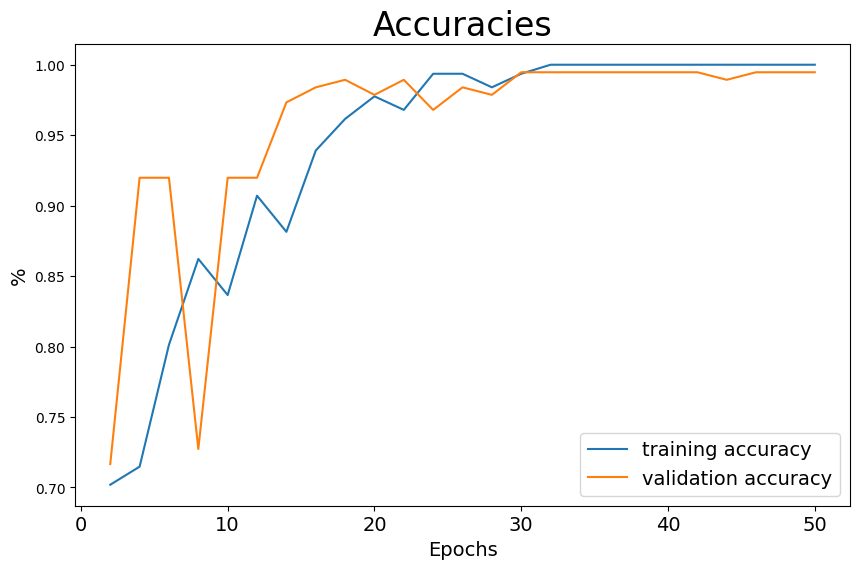

In [637]:
# Instantiate figure and axe object
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(list(acc_train.keys()), list(acc_train.values()), label="training accuracy")
plt.plot(list(acc_val.keys()), list(acc_val.values()), label="validation accuracy")
plt.title("Accuracies", fontsize=24)
plt.ylabel("%", fontsize=14)
plt.xlabel("Epochs", fontsize=14)
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.legend(loc='best', fontsize=14)
plt.show()

In [638]:
# Read model from file
model = torch.load("model.pth")
model.eval()

CNN(
  (model_layers): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=266944, out_features=120, bias=True)
    (8): ReLU()
    (9): Linear(in_features=120, out_features=120, bias=True)
    (10): Linear(in_features=120, out_features=120, bias=True)
    (11): Linear(in_features=120, out_features=120, bias=True)
    (12): Linear(in_features=120, out_features=2, bias=True)
  )
)

In [639]:
print(f"test accuracy: {val_test(test_loader,model)[0]*100:0.1f}%")

test accuracy: 100.0%


In [640]:
%matplotlib inline

# Call test function
tup = val_test(test_loader, model)

# Check if wrong predictions occur
if len(tup[1])>=1:
    
    # Loop over wrongly predicted images
    for i, t in enumerate(tup[1]):
        plt.figure(figsize=(7,5))
        img, y_pred, y_true = t
        img = img.to("cpu").reshape(400, 700)
        plt.imshow(img, cmap="gray")
        plt.title(f"Image {i+1} - Predicted: {y_pred}, True: {y_true}", fontsize=24)
        plt.axis("off")
        plt.show()
        plt.close()
else:
    print("No wrong predictions!")

No wrong predictions!


In [641]:
# Load the required libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from PIL import Image
import os

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the CNN model exactly as in chapter 2.8
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()

        # Define model layers
        self.model_layers = nn.Sequential(

            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Flatten(),
            nn.Linear(16*97*172, 120),
            nn.ReLU(),
            nn.Linear(120, 2),
            #nn.LogSoftmax(dim=1)
        )
        
    def forward(self, x):
        out = self.model_layers(x)
        return out

# Load the model's parameters
model = torch.load("model.pth")
model.eval()

CNN(
  (model_layers): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=266944, out_features=120, bias=True)
    (8): ReLU()
    (9): Linear(in_features=120, out_features=120, bias=True)
    (10): Linear(in_features=120, out_features=120, bias=True)
    (11): Linear(in_features=120, out_features=120, bias=True)
    (12): Linear(in_features=120, out_features=2, bias=True)
  )
)

In [642]:
# Define custom dataset
class Predict_Set(Dataset):
    def __init__(self, img_folder, transform):
        self.img_folder = img_folder
        self.transform = transform
        self.img_lst = os.listdir(self.img_folder)

    def __len__(self):
        return len(self.img_lst)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_folder, self.img_lst[idx])
        img = Image.open(img_path)
        img = img.crop((50, 60, 750, 460))  #Size: 700x400
        img.load()
        img_tensor = self.transform(img)
        return img_tensor, self.img_lst[idx]

In [643]:
# Path to images (preferably local to accelerate loading)
path = "data/Coil_Vision/02_predict"

# Transform function for loading
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5), (0.5))])

# Create dataset as instance of custom dataset
predict_set = Predict_Set(path, transform=transform)

# Define loader
predict_loader = DataLoader(dataset=predict_set)

In [644]:
def predict(dataloader, model):

    # Turn off gradient calculation
    with torch.no_grad():
        
        img_lst = []; y_pred_lst = []; name_lst = []
        # Loop over data loader
        for image, name in dataloader:
            img_lst.append(image)
            image = image.to(device)
            
            # Get raw values from model
            output = model(image)
            
            # Derive prediction
            y_pred = output.argmax(1)
            y_pred_lst.append(y_pred.item())
            name_lst.append(name[0])
            
    return img_lst, y_pred_lst, name_lst


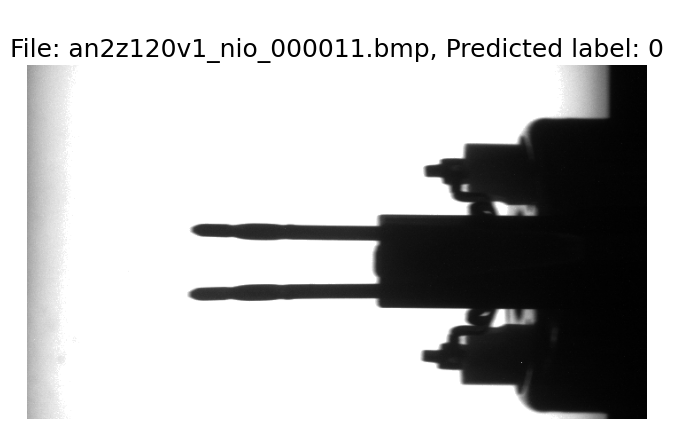

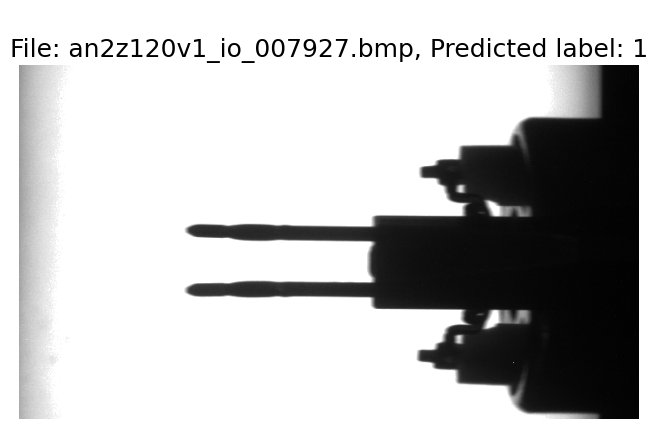

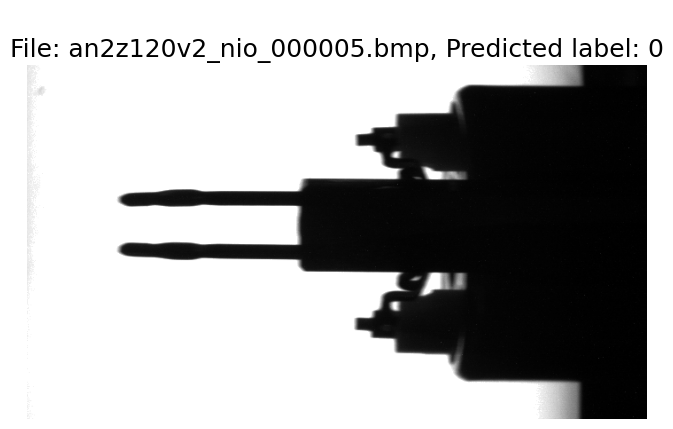

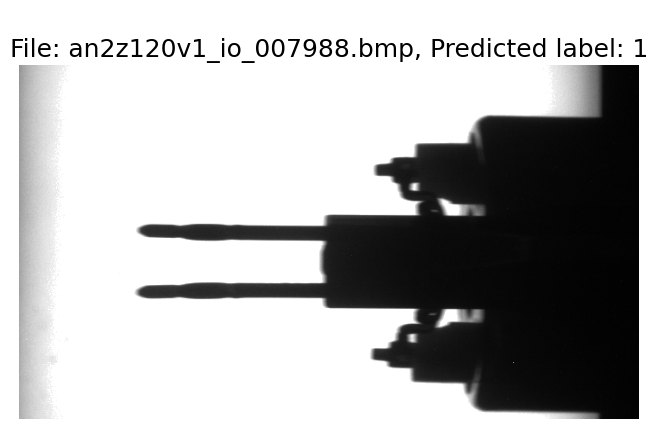

In [645]:
# Predict labels for images
imgs, lbls, names  = predict(predict_loader, model)

# Iterate over classified images
for idx, image in enumerate(imgs):
    plt.figure(figsize=(8,6))
    plt.imshow(image.squeeze(), cmap="gray")
    plt.title(f"\nFile: {names[idx]}, Predicted label: {lbls[idx]}", fontsize=18)
    plt.axis("off")
    plt.show()
    plt.close()

In [646]:
# Empty lists to store the layers and the weights
all_layers = []; conv_weights = []

# Iterate over the model's structure
# (First level nn.Sequential)
for _, layer in enumerate(list(model.children())[0]):
    if type(layer) == nn.Conv2d:
        all_layers.append(layer)
        conv_weights.append(layer.weight)
    elif type(layer) in [nn.ReLU, nn.MaxPool2d]:
        all_layers.append(layer)
        conv_weights.append("*")

# Print layers and dimensions of weights
for idx, layer in enumerate(all_layers):
    print(f"{idx+1}. Layer: {layer}")
    if type(layer) == nn.Conv2d:
        print(f"          weights: {conv_weights[idx].shape}")
    else:
        print(f"          weights: {conv_weights[idx]}")
    print()

1. Layer: Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
          weights: torch.Size([6, 1, 5, 5])

2. Layer: ReLU()
          weights: *

3. Layer: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          weights: *

4. Layer: Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
          weights: torch.Size([16, 6, 5, 5])

5. Layer: ReLU()
          weights: *

6. Layer: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          weights: *

7. Layer: ReLU()
          weights: *




1. Layer: Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1)) 



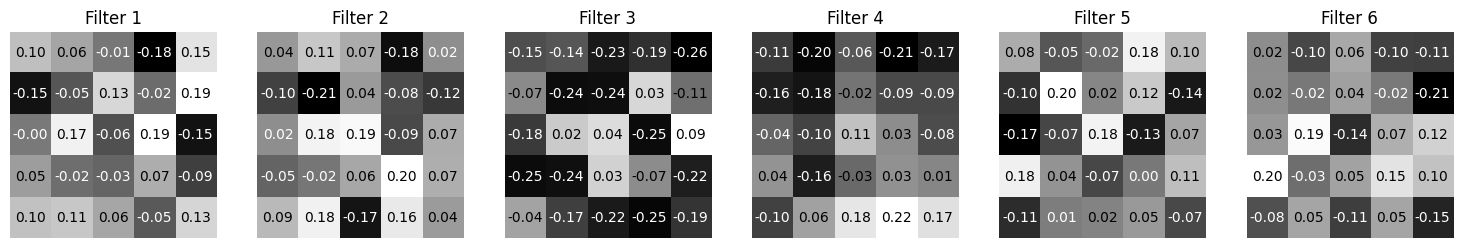


4. Layer: Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1)) 



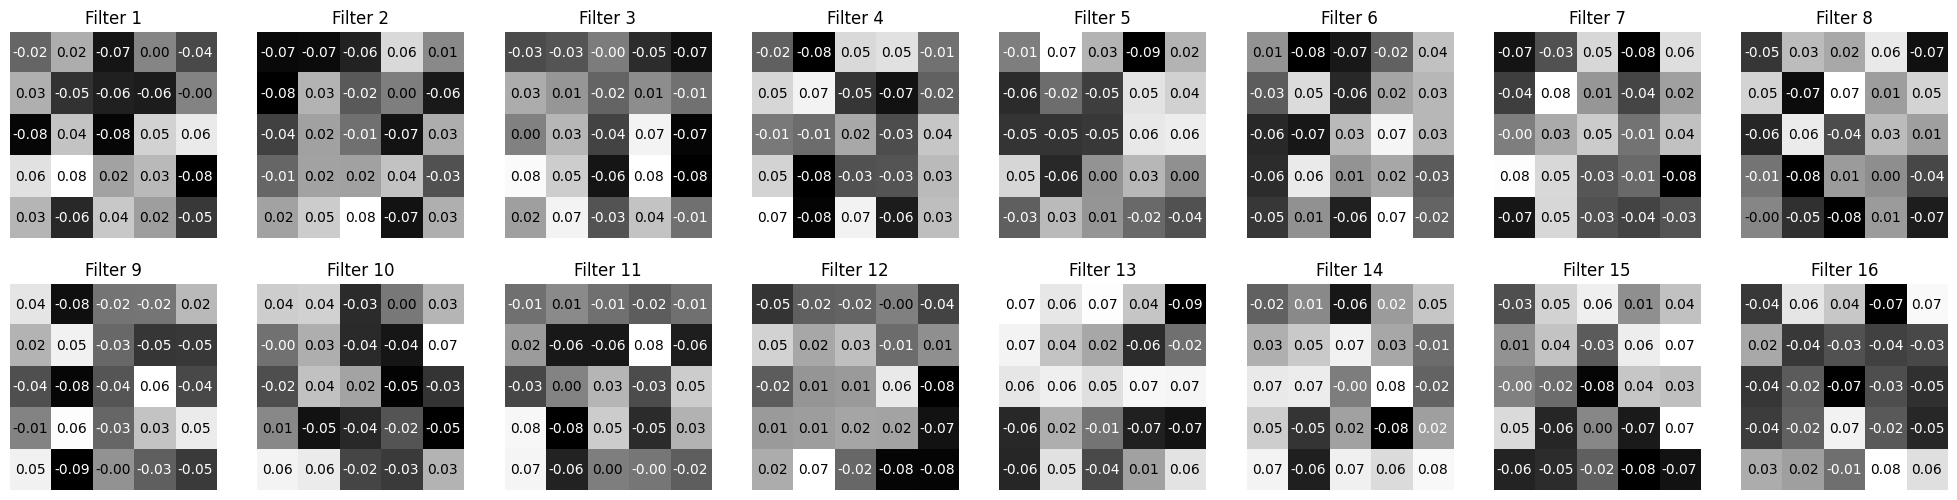

In [647]:
import itertools

# Iterate through all layers
for idx_out, layer in enumerate(all_layers):
    
    # If layer is a convolutional filter
    if type(layer) == nn.Conv2d:
        
        # Print layer name
        print(f"\n{idx_out+1}. Layer: {layer} \n")
        
        # Prepare plot and weights
        plt.figure(figsize=(25,6))
        weights = conv_weights[idx_out][:,0,:,:] # only first input channel
        weights = weights.detach().to('cpu')
        
        # Enumerate over filter weights (only first input channel)
        for idx_in, f in enumerate(weights):
            plt.subplot(2,8, idx_in+1)
            plt.imshow(f, cmap="gray")
            plt.title(f"Filter {idx_in+1}")
            
            # Print texts
            for i, j in itertools.product(range(f.shape[0]), range(f.shape[1])):
                if f[i,j] > f.mean():
                    color = 'black'
                else:
                    color = 'white'
                plt.text(j, i, format(f[i, j], '.2f'), horizontalalignment='center', verticalalignment='center', color=color)
            
            plt.axis("off")
        plt.show()
        plt.close()    


Image has shape: torch.Size([1, 1, 400, 700])



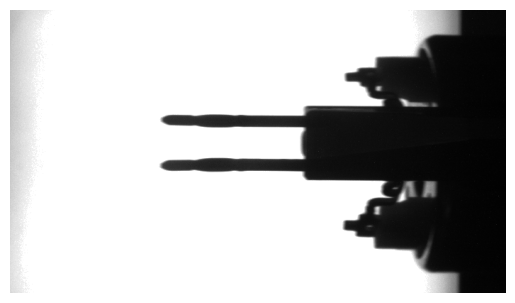

In [648]:
# Test loader has a batch size of 1
img = next(iter(test_loader))[0].to(device)
print(f"\nImage has shape: {img.shape}\n")

# Plot image
img_copy = img.to('cpu')
plt.imshow(img_copy.reshape(400,700), cmap="gray")
plt.axis("off")
plt.show()

In [649]:
# Pass the image through the first layer
results = [all_layers[0](img)]

# Pass the results of the previous layer to the next layer
for idx in range(1, len(all_layers)):  # Start at 1, first layer already passed!
    results.append(all_layers[idx](results[-1]))  # Pass the last result to the layer


In [650]:
def gradCAM(x):
    
    # Run model and predict
    logits = model(x)
    pred = logits.max(-1)[-1] # Returns index of max value (0 or 1)
    
    # Fetch activations at final conv layer
    last_conv = model.model_layers[:5]
    activations = last_conv(x)

    # Compute gradients with respect to model's prediction
    model.zero_grad()
    logits[0,pred].backward(retain_graph=True)
    
    # Compute average gradient per output channel of last conv layer
    pooled_grads = model.model_layers[3].weight.grad.mean((1,2,3))
    
    # Multiply each output channel with its corresponding average gradient
    for i in range(activations.shape[1]):
        activations[:,i,:,:] *= pooled_grads[i]
    
    # Compute heatmap as average over all weighted output channels
    heatmap = torch.mean(activations, dim=1)[0].cpu().detach()
    
    return heatmap

In [651]:
import cv2

def upsampleHeatmap(map, img):
    m,M = map.min(), map.max()
    i,I = img.min(), img.max()
    map = 255 * ((map-m) / (M-m))
    img = 255 * ((img-i) / (I-i))
    map = np.uint8(map)
    img = np.uint8(img)
    map = cv2.resize(map, (700,400))
    map = cv2.applyColorMap(255-map, cv2.COLORMAP_JET)
    map = np.uint8(map)
    img = cv2.applyColorMap(255-img, cv2.COLORMAP_JET)
    img = np.uint8(img)
    map = np.uint8(map*0.7 + img*0.3)
    return map

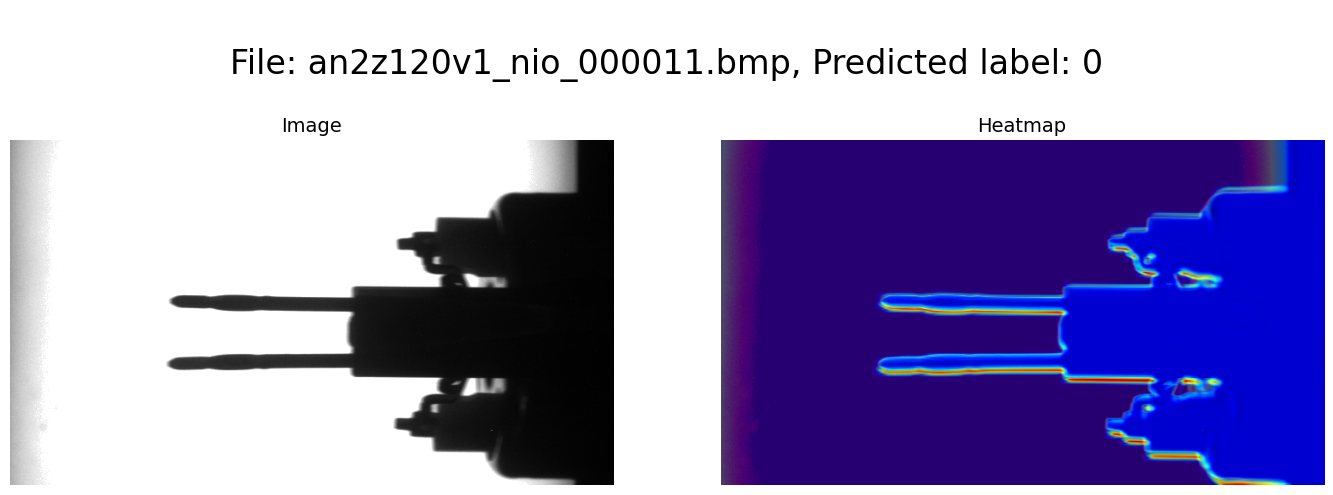

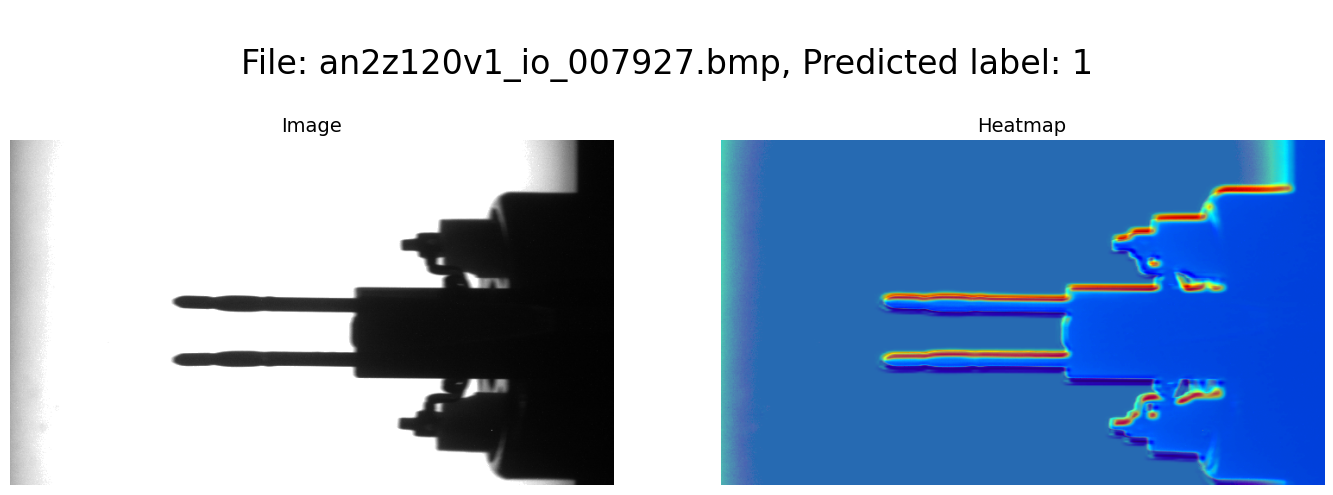

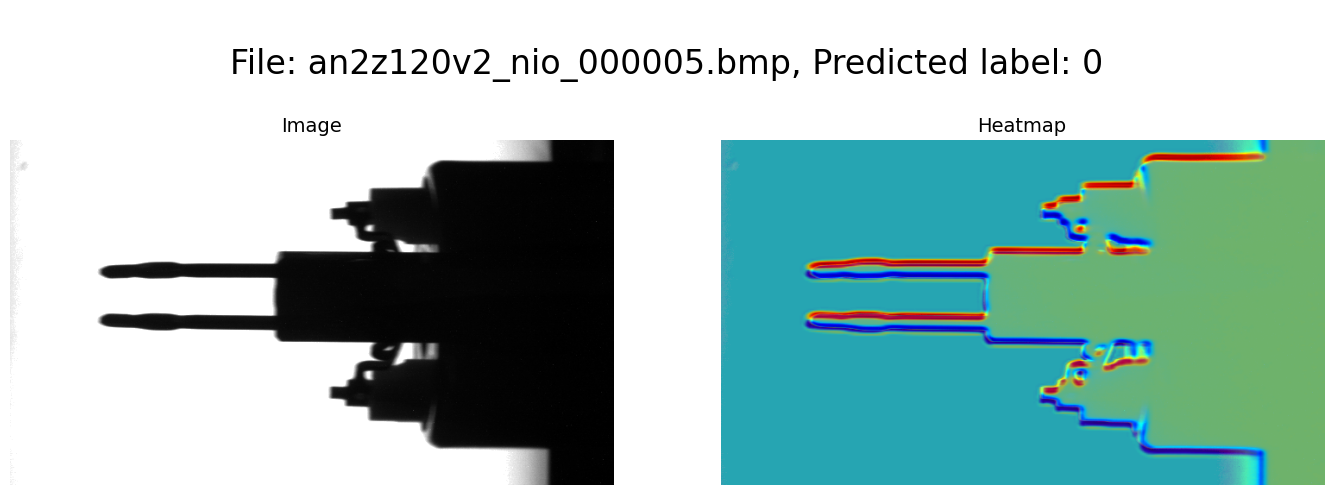

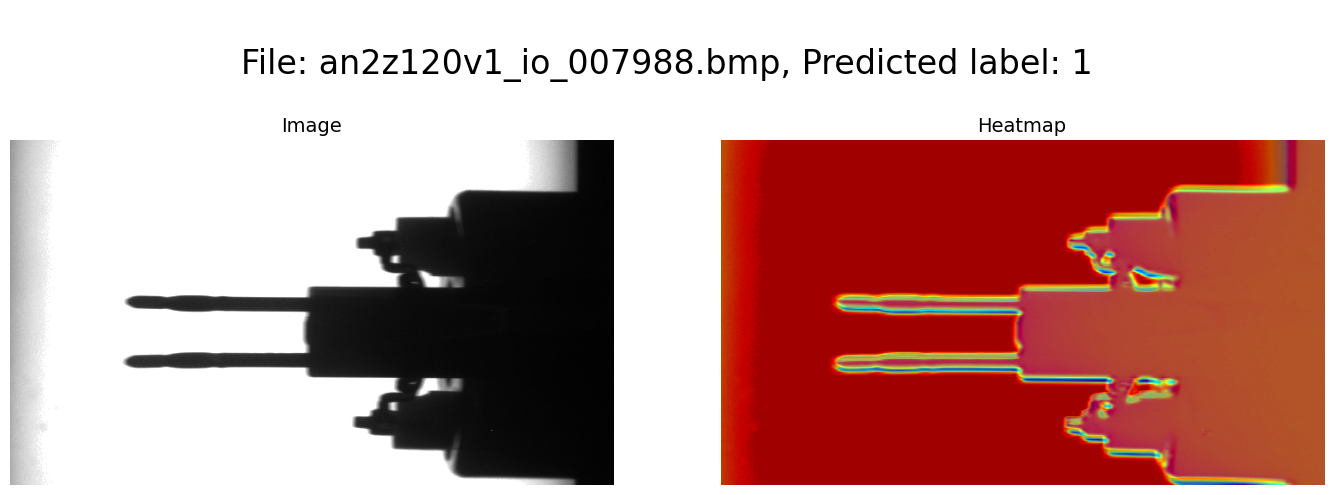

In [652]:
# Iterate over dataloader
for idx, (image, name) in enumerate(predict_loader):
    
    # Compute heatmap
    image = image.to(device)
    heatmap = gradCAM(image)
    image = image.cpu().squeeze(0).permute(1,2,0)
    heatmap = upsampleHeatmap(heatmap, image)
    
    # Plot images and heatmaps
    fig = plt.figure(figsize=(14,5))
    fig.suptitle(f"\nFile: {names[idx]}, Predicted label: {lbls[idx]}\n", fontsize=24)
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap="gray")
    plt.title(f"Image", fontsize=14)
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(heatmap)
    plt.title(f"Heatmap", fontsize=14)
    plt.tight_layout()
    plt.axis("off")
    plt.show()
    plt.close()